In [1]:
import random

flatten = lambda l: [item for sublist in l for item in sublist]

class Game:
    ACTION_UP = 0
    ACTION_LEFT = 1
    ACTION_DOWN = 2
    ACTION_RIGHT = 3

    ACTIONS = [ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT, ACTION_UP]

    ACTION_NAMES = ["UP   ", "LEFT ", "DOWN ", "RIGHT"]

    MOVEMENTS = {
        ACTION_UP: (1, 0),
        ACTION_RIGHT: (0, 1),
        ACTION_LEFT: (0, -1),
        ACTION_DOWN: (-1, 0)
    }

    num_actions = len(ACTIONS)

    def __init__(self, n, m, wrong_action_p=0.1, alea=False):
        self.n = n
        self.m = m
        self.wrong_action_p = wrong_action_p
        self.alea = alea
        self.generate_game()

    def _position_to_id(self, x, y):
        """Donne l'identifiant de la position entre 0 et 15"""
        return x + y * self.n

    def _id_to_position(self, id):
        """Réciproque de la fonction précédente"""
        return (id % self.n, id // self.n)

    def generate_game(self):
        cases = [(x, y) for x in range(self.n) for y in range(self.m)]
        hole = random.choice(cases)
        cases.remove(hole)
        start = random.choice(cases)
        cases.remove(start)
        end = random.choice(cases)
        cases.remove(end)
        block = random.choice(cases)
        cases.remove(block)

        self.position = start
        self.end = end
        self.hole = hole
        self.block = block
        self.counter = 0
        
        if not self.alea:
            self.start = start
        return self._get_state()
    
    def reset(self):
        if not self.alea:
            self.position = self.start
            self.counter = 0
            return self._get_state()
        else:
            return self.generate_game()

    def _get_grille(self, x, y):
        grille = [
            [0] * self.n for i in range(self.m)
        ]
        grille[x][y] = 1
        return grille

    def _get_state(self):
        x, y = self.position
        if self.alea:
            return np.reshape([self._get_grille(x, y) for (x, y) in
                    [self.position, self.end, self.hole, self.block]], (1, 64))
        return flatten(self._get_grille(x, y))
    
    def get_random_action(self):
        return random.choice(self.ACTIONS)
    
    def move(self, action):
        """
        takes an action parameter
        :param action : the id of an action
        :return ((state_id, end, hole, block), reward, is_final, actions)
        """

        self.counter += 1

        if action not in self.ACTIONS:
            raise Exception("Invalid action")

        # random actions sometimes (2 times over 10 default)
        choice = random.random()
        if choice < self.wrong_action_p:
            action = (action + 1) % 4
        elif choice < 2 * self.wrong_action_p:
            action = (action - 1) % 4

        d_x, d_y = self.MOVEMENTS[action]
        x, y = self.position
        new_x, new_y = x + d_x, y + d_y

        if self.block == (new_x, new_y):
            return self._get_state(), -1, False, self.ACTIONS
        elif self.hole == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), -10, True, None
        elif self.end == (new_x, new_y):
            self.position = new_x, new_y
            return self._get_state(), 10, True, self.ACTIONS
        elif new_x >= self.n or new_y >= self.m or new_x < 0 or new_y < 0:
            return self._get_state(), -1, False, self.ACTIONS
        elif self.counter > 200:
            self.position = new_x, new_y
            return self._get_state(), -10, True, self.ACTIONS
        else:
            self.position = new_x, new_y
            return self._get_state(), -1, False, self.ACTIONS

    def print(self):
        str = ""
        for i in range(self.n - 1, -1, -1):
            for j in range(self.m):
                if (i, j) == self.position:
                    str += "x"
                elif (i, j) == self.block:
                    str += "¤"
                elif (i, j) == self.hole:
                    str += "o"
                elif (i, j) == self.end:
                    str += "@"
                else:
                    str += "."
            str += "\n"
        print(str)

In [7]:
# defining the neural network
import numpy as np
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop, Adam, sgd
from keras.layers.advanced_activations import LeakyReLU
import random
import os

from collections import deque


class Trainer:
    def __init__(self, name=None, learning_rate=0.001, epsilon_decay=0.9999, batch_size=30, memory_size=3000):
        self.state_size = 64
        self.action_size = 4
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay
        self.learning_rate = learning_rate
        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        
        self.name = name
        if name is not None and os.path.isfile("model-" + name):
                model = load_model("model-" + name)
        else:
            model = Sequential()
            model.add(Dense(50, input_dim=self.state_size, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(30, activation='relu'))
            model.add(Dense(self.action_size, activation='linear'))
            model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        self.model = model
        
    def decay_epsilon(self):
        self.epsilon *= self.epsilon_decay
    
    def get_best_action(self, state, rand=True):

        if rand and np.random.rand() <= self.epsilon:
            # The agent acts randomly
            return random.randrange(self.action_size)
        
        # Predict the reward value based on the given state
        act_values = self.model.predict(np.array(state))

        # Pick the action based on the predicted reward
        action =  np.argmax(act_values[0])  
        return action

    def remember(self, state, action, reward, next_state, done):
        self.memory.append([state, action, reward, next_state, done])

    def replay(self, batch_size):
        batch_size = min(batch_size, len(self.memory))

        minibatch = random.sample(self.memory, batch_size)

        inputs = np.zeros((batch_size, self.state_size))
        outputs = np.zeros((batch_size, self.action_size))

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = self.model.predict(state)[0]
            if done:
                target[action] = reward
            else:
                target[action] = reward + self.gamma * np.max(self.model.predict(next_state))

            inputs[i] = state
            outputs[i] = target

        return self.model.fit(inputs, outputs, epochs=1, verbose=0, batch_size=batch_size)

    def save(self, id=None, overwrite=False):
        name = 'model'
        if self.name:
            name += '-' + self.name
        else:
            name += '-' + str(time.time())
        if id:
            name += '-' + id
        self.model.save(name, overwrite=overwrite)



In [8]:
def smooth(vector, width=30):
    return np.convolve(vector, [1/width]*width, mode='valid')

In [9]:
import time 
from IPython.core.debugger import set_trace

def train(episodes, trainer, wrong_action_p, alea, collecting=False, snapshot=5000):
    batch_size = 32
    g = Game(4, 4, wrong_action_p, alea=alea)
    counter = 1
    scores = []
    global_counter = 0
    losses = [0]
    epsilons = []

    # we start with a sequence to collect information, without learning
    if collecting:
        collecting_steps = 10000
        print("Collecting game without learning")
        steps = 0
        while steps < collecting_steps:
            state = g.reset()
            done = False
            while not done:
                steps += 1
                action = g.get_random_action()
                next_state, reward, done, _ = g.move(action)
                trainer.remember(state, action, reward, next_state, done)
                state = next_state

    print("Starting training")  
    global_counter = 0
    for e in range(episodes+1):
        state = g.generate_game()
        state = np.reshape(state, [1, 64])
        score = 0
        done = False
        steps = 0
        while not done:
            steps += 1
            global_counter += 1
            action = trainer.get_best_action(state)
            trainer.decay_epsilon()
            next_state, reward, done, _ = g.move(action)
            next_state = np.reshape(next_state, [1, 64])
            score += reward
            trainer.remember(state, action, reward, next_state, done)
            state = next_state
            if global_counter % 100 == 0:
                l = trainer.replay(batch_size)
                losses.append(l.history['loss'][0])
            if done:
                scores.append(score)
                epsilons.append(trainer.epsilon)
            if steps > 200:
                break
        if e % 200 == 0:
            print("episode: {}/{}, moves: {}, score: {}, epsilon: {}, loss: {}"
                  .format(e, episodes, steps, score, trainer.epsilon, losses[-1]))
        if e > 0 and e % snapshot == 0:
            trainer.save(id='iteration-%s' % e)
    return scores, losses, epsilons

In [10]:
trainer = Trainer(learning_rate=0.001, epsilon_decay=0.999995)

In [11]:
scores, losses, epsilons = train(35000, trainer, 0.1, True, snapshot=2500)

Starting training
episode: 0/35000, moves: 4, score: -13, epsilon: 0.9999800001499994, loss: 0

episode: 200/35000, moves: 3, score: 8, epsilon: 0.9827848600063058, loss: 2.2650773525238037
episode: 400/35000, moves: 134, score: -143, epsilon: 0.963088381607055, loss: 0.11147177219390869
episode: 600/35000, moves: 10, score: 1, epsilon: 0.9454917276276724, loss: 1.303665280342102
episode: 800/35000, moves: 7, score: -16, epsilon: 0.9295681248375635, loss: 1.9372859001159668
episode: 1000/35000, moves: 19, score: -8, epsilon: 0.9138304525055191, loss: 0.0655217319726944
episode: 1200/35000, moves: 54, score: -63, epsilon: 0.8993164850036363, loss: 1.7543643712997437
episode: 1400/35000, moves: 1, score: -10, epsilon: 0.881614569073129, loss: 2.16178035736084
episode: 1600/35000, moves: 1, score: 10, epsilon: 0.867868256306871, loss: 1.8589626550674438
episode: 1800/35000, moves: 58, score: -47, epsilon: 0.8541910536450193, loss: 5.119916915893555
episode: 2000/35000, moves: 4, score: -1

episode: 16600/35000, moves: 48, score: -57, epsilon: 0.28042522176564094, loss: 5.900455474853516
episode: 16800/35000, moves: 27, score: -16, epsilon: 0.27741014343985765, loss: 2.000018835067749
episode: 17000/35000, moves: 4, score: 7, epsilon: 0.2748531761488919, loss: 2.8931164741516113
episode: 17200/35000, moves: 2, score: 9, epsilon: 0.27311338381757744, loss: 1.7443770170211792
episode: 17400/35000, moves: 1, score: -10, epsilon: 0.2705960209681615, loss: 1.8595048189163208
episode: 17600/35000, moves: 1, score: 10, epsilon: 0.2677776534824854, loss: 0.6675370335578918
episode: 17800/35000, moves: 6, score: 5, epsilon: 0.2658087237644987, loss: 3.135671854019165
episode: 18000/35000, moves: 15, score: -4, epsilon: 0.2636630458001241, loss: 2.104271173477173
episode: 18200/35000, moves: 5, score: -14, epsilon: 0.26176755837948434, loss: 1.3987722396850586
episode: 18400/35000, moves: 5, score: 6, epsilon: 0.2598012483778873, loss: 4.238536357879639
episode: 18600/35000, moves:

episode: 33600/35000, moves: 4, score: 7, epsilon: 0.15752365831630968, loss: 3.51813006401062
episode: 33800/35000, moves: 8, score: 3, epsilon: 0.15655864107555248, loss: 1.2864532470703125
episode: 34000/35000, moves: 7, score: 4, epsilon: 0.15539505627176287, loss: 3.7839856147766113
episode: 34200/35000, moves: 2, score: 9, epsilon: 0.15434503874690592, loss: 1.3473284244537354
episode: 34400/35000, moves: 1, score: -10, epsilon: 0.15346930710635284, loss: 2.0087509155273438
episode: 34600/35000, moves: 7, score: 4, epsilon: 0.1526275407921657, loss: 2.8231284618377686
episode: 34800/35000, moves: 1, score: 10, epsilon: 0.15180025821659057, loss: 4.58963680267334
episode: 35000/35000, moves: 2, score: -11, epsilon: 0.1506456735941451, loss: 2.351165294647217


<Figure size 432x288 with 0 Axes>

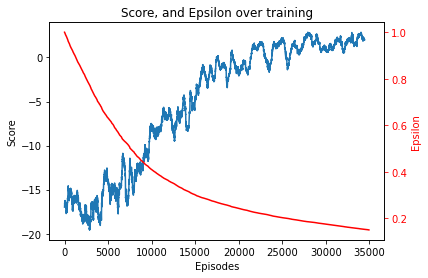

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
sc = smooth(scores, width=500)


fig, ax1 = plt.subplots()
ax1.plot(sc)
ax2 = ax1.twinx()
ax2.plot(epsilons, color='r')
ax1.set_ylabel('Score')
ax2.set_ylabel('Epsilon', color='r')
ax2.tick_params('y', colors='r')
plt.title("Score, and Epsilon over training")
ax1.set_xlabel("Episodes")
plt.figure()

In [13]:
from IPython import display
import time
g = Game(4, 4, 0.1, alea=True)

In [18]:
state = g.reset()
state = g._get_state()
print("state")
print("  ")
g.print()
done = False
time.sleep(5)
while not done:
    time.sleep(1)
    display.clear_output(wait=True)
    print(trainer.model.predict(np.array(g._get_state())))
    action = trainer.get_best_action(g._get_state(), rand=False)
    print(Game.ACTION_NAMES[action])
    next_state, reward, done, _ = g.move(action)
    g.print()
print(reward)

[[7.3228064 6.648551  4.6770315 5.2907867]]
UP   
x...
....
...o
...¤

10
